# 1) Churn analysis

- Churn = measure of users ending subscription / contract 

- Objective = predict users LIKELY to churn from the current list of active users 

- Application = devise retention programmes, market to those most 'vulnerable' to churn. 

In [1]:
import numpy as np
import pandas as pd 
import os 

import matplotlib 
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import matplotlib.pyplot as plt
plt.style.use(['fivethirtyeight', 'dark_background'])
import seaborn as sns
from PIL import Image

import itertools
import warnings 
warnings.filterwarnings('ignore')

import io
import plotly.offline as py 
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn import preprocessing
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
# Replace empty space with null 
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

# Only keep non nulls 
df = df[df['TotalCharges'].notnull()]

# df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
# coerce necessary, unable to parse string otherwise

# Convert to float 
df['TotalCharges'] = df['TotalCharges'].astype(float)

df = df.reset_index()[df.columns]

In [5]:
#replace 'No internet service' to No for the following columns

replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']

for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

In [6]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1:'Yes',
                                                   0:'No'})

In [7]:
# Convert tenure to categorical 

def tenure_lab(df):
    
    if df['tenure'] <= 10:
        return "tenure-0-10"
    elif (df['tenure'] > 10) & (df['tenure'] <= 20):
        return 'tenure-11-20'
    elif (df['tenure'] > 21) & (df['tenure'] <= 30):
        return 'tenure-21-30'
    elif (df['tenure'] > 31) & (df['tenure'] <= 40):
        return 'tenure-31-40'
    elif (df['tenure'] > 41) & (df['tenure'] <= 50):
        return 'tenure-41-50'
    elif (df['tenure'] > 51) & (df['tenure'] <= 60):
        return 'tenure-51-60'
    elif df['tenure'] > 60:
        return 'tenure-60+'
    
df['tenure_group'] = df.apply(lambda df:tenure_lab(df),
                              axis = 1)

In [8]:
churn = df[df['Churn'] == 'Yes']
unchurn = df[df['Churn'] == 'No']

In [9]:
print('\nMissing values: ', df.isnull().sum().values.sum())
print('\nUnique values: ', df.nunique())


Missing values:  266

Unique values:  customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
tenure_group           7
dtype: int64


In [10]:
# Separate cats and nums 
ID = ['customerID']
target = ['Churn']

cat_col = df.nunique()[df.nunique() < 6].keys().tolist()
cat_col = [x for x in cat_col if x not in target]

num_col = [x for x in df.columns if x not in cat_col + target + ID]

In [11]:
cat_col

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [12]:
num_col

['tenure', 'MonthlyCharges', 'TotalCharges', 'tenure_group']

In [13]:
df.head()

customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female            No     Yes         No       1           No   
1  5575-GNVDE    Male            No      No         No      34          Yes   
2  3668-QPYBK    Male            No      No         No       2          Yes   
3  7795-CFOCW    Male            No      No         No      45           No   
4  9237-HQITU  Female            No      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...         Yes   
4                No     Fiber optic             No  ...          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1          No              No        One year               No   
2          No              No  Month-to-month              Yes   
3          No              No        One year               No   
4          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges  Churn  tenure_group  
0           Electronic check          29.85        29.85     No   tenure-0-10  
1               Mailed check          56.95      1889.50     No  tenure-31-40  
2               Mailed check          53.85       108.15    Yes   tenure-0-10  
3  Bank transfer (automatic)          42.30      1840.75     No  tenure-41-50  
4           Electronic check          70.70       151.65    Yes   tenure-0-10  

[5 rows x 22 columns]

In [14]:
churn.head()

customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService  \
2   3668-QPYBK    Male            No      No         No       2          Yes   
4   9237-HQITU  Female            No      No         No       2          Yes   
5   9305-CDSKC  Female            No      No         No       8          Yes   
8   7892-POOKP  Female            No     Yes         No      28          Yes   
13  0280-XJGEX    Male            No      No         No      49          Yes   

   MultipleLines InternetService OnlineSecurity  ... TechSupport StreamingTV  \
2             No             DSL            Yes  ...          No          No   
4             No     Fiber optic             No  ...          No          No   
5            Yes     Fiber optic             No  ...          No         Yes   
8            Yes     Fiber optic             No  ...         Yes         Yes   
13           Yes     Fiber optic             No  ...          No         Yes   

   StreamingMovies        Contract PaperlessBilling  \
2               No  Month-to-month              Yes   
4               No  Month-to-month              Yes   
5              Yes  Month-to-month              Yes   
8              Yes  Month-to-month              Yes   
13             Yes  Month-to-month              Yes   

                PaymentMethod MonthlyCharges TotalCharges  Churn  tenure_group  
2                Mailed check          53.85       108.15    Yes   tenure-0-10  
4            Electronic check          70.70       151.65    Yes   tenure-0-10  
5            Electronic check          99.65       820.50    Yes   tenure-0-10  
8            Electronic check         104.80      3046.05    Yes  tenure-21-30  
13  Bank transfer (automatic)         103.70      5036.30    Yes  tenure-41-50  

[5 rows x 22 columns]

# 2) Categorical features

#### Based on churn

- Visualize all categorical features according to churn percent 

In [15]:
labels = df['Churn'].value_counts().keys().tolist()

values = df['Churn'].value_counts().values.tolist()

In [16]:
trace = go.Pie(labels = labels,
               values = values,
               marker = dict(colors = ['dodgerblue', 'maroon'],
                              line = dict(color = 'white',
                                          width = .8)
                             ),
              hoverinfo = 'label+value+text',
              hole = .4
              )

layout = go.Layout(dict(title = 'Churn percentages')
                  )

data = [trace]
fig = go.Figure(data = data, 
                layout = layout)

py.iplot(fig)

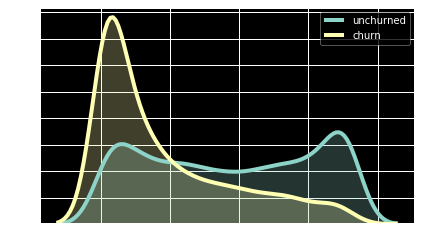

In [17]:
sns.kdeplot(df['tenure'].loc[df['Churn'] == 'No'],
            label = 'unchurned', shade = True);

sns.kdeplot(df['tenure'].loc[df['Churn'] == 'Yes'],
            label = 'churn', shade = True);

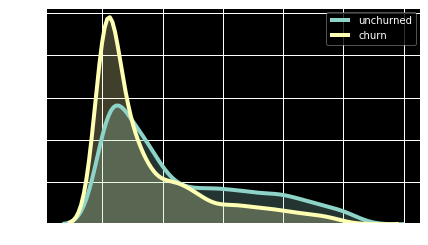

In [18]:
sns.kdeplot(df['TotalCharges'].loc[df['Churn'] == 'No'],
            label = 'unchurned', shade = True);

sns.kdeplot(df['TotalCharges'].loc[df['Churn'] == 'Yes'],
            label = 'churn', shade = True);

In [19]:
def pie_chart(column):
    
    trace1 = go.Pie(values = churn[column].value_counts().values.tolist(),
                    labels = churn[column].value_counts().keys().tolist(),
                    hoverinfo = 'label+percent+name',
                    domain = dict(x = [0, .5]),
                    name = 'churned',
                    marker = dict(colors = ['dodgerblue', 'maroon'],
                                  line = dict(color = 'white',
                                              width = .8)
                                 ),
                    hole = .6
                   )
    
    trace2 = go.Pie(values = unchurn[column].value_counts().values.tolist(),
                    labels = unchurn[column].value_counts().keys().tolist(),
                    hoverinfo = 'label+percent+name',
                    marker = dict(colors = ['dodgerblue', 'maroon'],
                                  line = dict(color = 'white',
                                              width = .8)
                                 ),
                    domain = dict(x = [.5, 1]),
                    hole = .6,
                    name = 'unchurned'
                   )
    
    layout = go.Layout(dict(title = column + 'churn distribution',
                            annotations = [dict(text = 'churned',
                                                font = dict(size = 10),
                                                showarrow = False,
                                                x = .20, y = .5),
                                          dict(text = 'unchurned',
                                               font = dict(size = 10),
                                               showarrow = False,
                                               x = .90, y = .5)
                                          ]
                           )
                      )
    
    data = [trace1, trace2]
    fig = go.Figure(data = data, 
                    layout = layout)
    py.iplot(fig)                                    

In [20]:
def histogram(column):
    
    trace1 = go.Histogram(x = churn[column],
                          histnorm = 'percent',
                          name = 'churned',
                          marker = dict(line = dict(color = 'white',
                                                    width = .5
                                                   )
                                       ),
                          opacity = 0.8
                         )
    
    trace2 = go.Histogram(x = churn[column],
                          histnorm = 'percent',
                          name = 'unchurned',
                          marker = dict(line = dict(color = 'black',
                                                    width = .5
                                                   )
                                       ),
                          opacity = 0.8
                         )
    
    data = [trace1, trace2]
    layout = go.Layout(dict(title = column + 'churn distribution',
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = column,
                                         zerolinewidth = 1,
                                         ticklen = 4,
                                         gridwidth = 2
                                        ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = 'percent',
                                         zerolinewidth = 1,
                                         ticklen = 5,
                                         gridwidth = 2
                                        ),
                           )
                      )
    
    fig = go.Figure(data = data, 
                    layout = layout)
    
    py.iplot(fig)

In [21]:
# Scatter plot matrix function 

def scatter_matrix(df):
    
    df = df.sort_values(by = 'Churn', ascending = True)
    classes = df['Churn'].unique().tolist()
    classes 
    
    class_code = {classes[k] : k for k in range(2)}
    class_code
    
    color_vals = [class_code[cl] for cl in df['Churn']]
    color_vals
    
    pl_colorscale = 'Portland'
    
    pl_colorscale
    
    text = [df.loc[k, 'Churn'] for k in range(len(df))]
    text
    
    trace = go.Splom(dimensions = [dict(label = 'tenure',
                                        values = df['tenure']),
                                   dict(label = 'MonthlyCharges',
                                        values = df['MonthlyCharges']),
                                   dict(label = 'TotalCharges',
                                        values = df['TotalCharges'])],
                    text = text,
                    marker = dict(color = color_vals,
                                  colorscale = pl_colorscale,
                                  size = 3,
                                  showscale = False,
                                  line = dict(width = .3,
                                              color = 'rgb(260, 260, 260)'
                                             )
                                 )
                    )
    
    axis = dict(showline = True,
                zeroline = False,
                gridcolor = '#fff',
                ticklen = 4
               )
    
    layout = go.Layout(dict(title = 'Scatter plot matrix for numerical features',
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    
    data = [trace]
    fig = go.Figure(data = data,
                    layout = layout)
    py.iplot(fig)

In [22]:
for c in cat_col:
    pie_chart(c)

In [23]:
for n in num_col:
    histogram(n)

In [24]:
scatter_matrix(df)

## 2.1) Tenure group churn 

In [25]:
tg_ch  =  churn['tenure_group'].value_counts().reset_index()
tg_ch.columns  = ['tenure_group','count']

tg_uch =  unchurn['tenure_group'].value_counts().reset_index()
tg_uch.columns = ['tenure_group','count']

In [26]:
tg_ch

tenure_group  count
0   tenure-0-10    968
1  tenure-11-20    283
2  tenure-21-30    157
3  tenure-31-40    125
4  tenure-41-50    101
5    tenure-60+     93
6  tenure-51-60     87

In [27]:
trace1 = go.Bar(x = tg_ch['tenure_group'], 
                y = tg_ch['count'],
                name = 'churned',
                marker = dict(line = dict(width = .5, 
                                          color = 'black')
                             ),
                opacity = .5)

trace2 = go.Bar(x = tg_uch['tenure_group'],
                y = tg_uch['count'],
                name = 'unchurned',
                marker = dict(line = dict(width = .5,
                                          color = 'black')
                             ),
                opacity = .8)

layout = go.Layout(dict(title = 'Subscriber churn in tenure groups',
                       xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                    title = 'tenure group',
                                    zerolinewidth = 1, 
                                    ticklen = 5, 
                                    gridwidth = 2),
                       yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                    title = 'count',
                                    zerolinewidth = 1,
                                    ticklen = 5, 
                                    gridwidth = 2),
                       )
                  )

data = [trace1, trace2]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

## 2.2) Monthly / Total charges 

In [28]:
df[['MonthlyCharges', 'TotalCharges', 'tenure', 'tenure_group']]

MonthlyCharges  TotalCharges  tenure  tenure_group
0              29.85         29.85       1   tenure-0-10
1              56.95       1889.50      34  tenure-31-40
2              53.85        108.15       2   tenure-0-10
3              42.30       1840.75      45  tenure-41-50
4              70.70        151.65       2   tenure-0-10
...              ...           ...     ...           ...
7027           84.80       1990.50      24  tenure-21-30
7028          103.20       7362.90      72    tenure-60+
7029           29.60        346.45      11  tenure-11-20
7030           74.40        306.60       4   tenure-0-10
7031          105.65       6844.50      66    tenure-60+

[7032 rows x 4 columns]

In [29]:
# Tenure group
def tenure_scatter(tenure_group, color):
    tracer = go.Scatter(x = df[df['tenure_group'] == tenure_group]['MonthlyCharges'],
                        y = df[df['tenure_group'] == tenure_group]['TotalCharges'],
                        mode = 'markers', 
                        marker = dict(line = dict(color = 'black',
                                                  width = .3),
                                      size = 5, 
                                      color = color,
                                      symbol = 'diamond-dot',
                                     ),
                        name = tenure_group,
                        opacity = .5
                       )
    return tracer

In [30]:
# Churn group

def churn_scatter(churn, color):
    tracer = go.Scatter(x = df[df['Churn'] == churn]['MonthlyCharges'],
                        y = df[df['Churn'] == churn]['TotalCharges'],
                               mode = 'markers',
                               marker = dict(line = dict(color = 'black',
                                                         width = .3),
                                             size = 4,
                                             color = color,
                                             symbol = 'diamond-dot',),
                              name = 'Churn - ' + churn,
                              opacity = .5)
    return tracer 

In [31]:
trace1 = tenure_scatter('tenure-0-10', 'orange')
trace2 = tenure_scatter('tenure-11-20', 'green')
trace3 = tenure_scatter('tenure-21-30', 'blue')
trace4 = tenure_scatter('tenure-31-40', 'red')
trace5 = tenure_scatter('tenure-41-50', 'grey')
trace6 = tenure_scatter('tenure-51-60', 'pink')
trace7 = tenure_scatter('tenure-60+', 'yellow')

trace8 = churn_scatter('Yes', 'red')
trace9 = churn_scatter('No', 'blue')

data1 = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]
data2 = [trace8, trace9]

def layout_title(title):
    layout = go.Layout(dict(title = title,
                            xaxis = dict(gridcolor = 'rgb(250, 250, 250)',
                                         title = 'Monthly charges',
                                         zerolinewidth = 1, 
                                         ticklen = 5, 
                                         gridwidth = 3),
                            yaxis = dict(gridcolor = 'rgb(250, 250, 250)',
                                         title = 'Total charges',
                                         zerolinewidth = 1, 
                                         ticklen = 5, 
                                         gridwidth = 2),
                            height = 500
                           )
                      )
    return layout

layout1 = layout_title('Charges by tenure')
layout2 = layout_title('Charges by churn')

fig1 = go.Figure(data = data1, layout = layout1)
fig2 = go.Figure(data = data2, layout = layout2)

py.iplot(fig1)
py.iplot(fig2)

## 2.2) Mean charges

In [32]:
mean_tenure_charge = df.groupby(['tenure_group','Churn'])[['MonthlyCharges',
                                                    'TotalCharges']].mean().reset_index()

mean_tenure_charge

tenure_group Churn  MonthlyCharges  TotalCharges
0    tenure-0-10    No       46.398890    221.302674
1    tenure-0-10   Yes       65.861777    247.494060
2   tenure-11-20    No       52.363040    804.542480
3   tenure-11-20   Yes       77.046996   1146.011307
4   tenure-21-30    No       57.608564   1487.098895
5   tenure-21-30   Yes       81.821338   2092.637261
6   tenure-31-40    No       60.701099   2172.276813
7   tenure-31-40   Yes       84.373600   3004.295200
8   tenure-41-50    No       64.072973   2961.701767
9   tenure-41-50   Yes       87.039604   4026.299010
10  tenure-51-60    No       67.913720   3806.790239
11  tenure-51-60   Yes       87.287931   4858.471264
12    tenure-60+    No       74.440563   5086.077549
13    tenure-60+   Yes       97.317742   6517.167204

In [33]:
# tracing function

def mean_charges(column, aggregate):
    tracer = go.Bar(x = mean_tenure_charge[mean_tenure_charge['Churn'] == aggregate]['tenure_group'],
                    y = mean_tenure_charge[mean_tenure_charge['Churn'] == aggregate][column],
                    name = aggregate, 
                    marker = dict(line = dict(width = 1)),
                    text = 'Churn'
                   )
    return tracer

# layout function

def layout_plot(title, xaxis_lab, yaxis_lab):
    layout = go.Layout(dict(title = title,
                            xaxis = dict(gridcolor = 'rgb(250, 250, 250)',
                                         title = xaxis_lab,
                                         zerolinewidth = 1,
                                         ticklen = 5,
                                         gridwidth = 3),
                            yaxis = dict(gridcolor = 'rgb(250, 250, 250)',
                                         title = yaxis_lab,
                                         zerolinewidth = 1, 
                                         ticklen = 5, 
                                         gridwidth = 2),
                           )
                      )
    return layout

In [34]:
trace1 = mean_charges('MonthlyCharges', 'Yes')
trace2 = mean_charges('MonthlyCharges', 'No')

layout1 = layout_plot('Mean monthly charges by tenure group',
                     'Tenure group', 'Monthly Charges')

data1 = [trace1, trace2]
fig1 = go.Figure(data = data1, 
                 layout = layout1)

trace3 = mean_charges('TotalCharges', 'Yes')
trace4 = mean_charges('TotalCharges', 'No')

layout2 = layout_plot('Mean total charges by tenure group',
                      'Tenure group', 'Total Charges')

data2 = [trace3, trace4]
fig2 = go.Figure(data = data2, 
                 layout = layout2)

py.iplot(fig1)
py.iplot(fig2)

# 3) Preprocessing 

In [35]:
df = df.drop(columns = 'tenure_group', axis = 1)

In [36]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [37]:
ID = ['customerID']
target_col = ['Churn']

cat_cols = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target]

num_cols = [x for x in df.columns if x not in cat_cols + target_col + ID]

In [38]:
# Binary col label encoding 

bin_cols = df.nunique()[df.nunique() == 2].keys().tolist()

le = LabelEncoder()
for i in bin_cols:
    df[i] = le.fit_transform(df[i])

In [39]:
# Multi val col

multi_cols = [i for i in cat_col if i not in bin_cols]

df = pd.get_dummies(data = df, 
                    columns = multi_cols)

In [40]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [41]:
# Scaling numerical col

# Scale data before applying PCA, to ensure unit variance
    # Fitting algorithms are highly dependent on scaling of features 
    
stc = StandardScaler() # StandardScaler subtracts the mean from each features and then scale to unit variance 
scaled = stc.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled, columns = num_cols)

In [42]:
# drop original values, 
copy = df.copy()

df = df.drop(columns = num_cols, axis = 1)

# merge scaled values for num_col
df = df.merge(scaled, 
              left_index = True, right_index = True,
              how = 'left'
             )

In [43]:
df.head()

customerID  gender  SeniorCitizen  Partner  Dependents  PhoneService  \
0  7590-VHVEG       0              0        1           0             0   
1  5575-GNVDE       1              0        0           0             1   
2  3668-QPYBK       1              0        0           0             1   
3  7795-CFOCW       1              0        0           0             0   
4  9237-HQITU       0              0        0           0             1   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  ...  \
0               0             1                 0            0  ...   
1               1             0                 1            0  ...   
2               1             1                 0            0  ...   
3               1             0                 1            1  ...   
4               0             0                 0            0  ...   

   Contract_Month-to-month  Contract_One year  Contract_Two year  \
0                        1                  0                  0   
1                        0                  1                  0   
2                        1                  0                  0   
3                        0                  1                  0   
4                        1                  0                  0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check    tenure  MonthlyCharges  TotalCharges  
0                           0 -1.280248       -1.161694     -0.994194  
1                           1  0.064303       -0.260878     -0.173740  
2                           1 -1.239504       -0.363923     -0.959649  
3                           0  0.512486       -0.747850     -0.195248  
4                           0 -1.239504        0.196178     -0.940457  

[5 rows x 30 columns]

# 4) Summary

In [44]:
summary = (copy[[i for i in copy.columns if i not in ID]].describe().transpose().reset_index())

summary = summary.rename(columns = {'index' : 'feature'})
summary = np.around(summary, 3)

In [45]:
val_list = [summary['feature'], summary['count'],
            summary['mean'], summary['std'],
            summary['min'], 
            summary['25%'],
            summary['50%'], 
            summary['75%'], 
            summary['max']]

In [46]:
trace = go.Table(header = dict(values = summary.columns.tolist(),
                               line = dict(color = ['black']),
                               fill = dict(color = ['dodgerblue']),
                               ),
                 cells = dict(values = val_list,
                              line = dict(color = ['black']),
                              fill = dict(color = ['aliceblue', 'cornflowerblue'])
                             ),
                columnwidth = [200, 60, 100, 100, 60, 60, 80, 80, 80]) # 9 summaries

layout = go.Layout(dict(title = 'Variable summary'))
figure = go.Figure(data = [trace], 
                   layout = layout)

py.iplot(figure)

# 5) Corr matrix 

In [47]:
corr = df.corr()

# tick labels 
matrix_col = corr.columns.tolist()

# Array conversion
corr_array = np.array(corr)

In [48]:
trace = go.Heatmap(z = corr_array,
                   x = matrix_col,
                   y = matrix_col,
                   colorscale = 'Viridis',
                   colorbar = dict(title = 'Pearson corr coeficient',
                                   titleside = 'right'
                                  ),
                  )

layout = go.Layout(dict(title = 'Corr matrix of variables',
                        height = 600,
                        width = 700,
                        yaxis = dict(tickfont = dict(size = 8)
                                    ),
                        xaxis = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig) # Hover to check coefficients 

# 5) Principal components

- PCs are calculated solely from features 
- no information from classes are considered 
- PCA = unsupervised i.e. no reference to labels 
- Nigh impossible to tell how initial features combined to form components 

> See [article](http://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

In [49]:
pca = PCA(n_components = 2)

X = df[[i for i in df.columns if i not in ID + target]]
Y = df[target + ID]

In [50]:
principal_comp = pca.fit_transform(X)

pca_data = pd.DataFrame(principal_comp, 
                        columns = ['PC1', 'PC2'])

pca_data = pca_data.merge(Y, 
                          left_index = True,
                          right_index = True, 
                          how = 'left')

pca_data['Churn'] = pca_data['Churn'].replace({1:'Churned',
                                               0:'Unchurned'})

In [51]:
def pca_scatter(target, color):
    tracer = go.Scatter(x = pca_data[pca_data['Churn'] == target]['PC1'], 
                        y = pca_data[pca_data['Churn'] == target]['PC2'],
                        name = target,
                        mode = 'markers',
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol = 'diamond-open'),
                        text = ('Customer Id :' + 
                                pca_data[pca_data['Churn'] == target]['customerID'])
                       )
    return tracer 

layout = go.Layout(dict(title = 'Principal components',
                        xaxis = dict(gridcolor = 'rgb(250, 250, 250)',
                                     title = 'PC1',
                                     zerolinewidth = 1, 
                                     ticklen = 5,
                                     gridwidth = 2),
                       yaxis = dict(gridcolor = 'rgb(250, 250, 250)',
                                    title = 'PC2',
                                    zerolinewidth = 1,
                                    ticklen = 5, 
                                    gridwidth = 2),
                       height = 600
                       )
                  )

trace1 = pca_scatter('Churned', 'crimson')
trace2 = pca_scatter('Unchurned', 'dodgerblue')

data = [trace1, trace2]

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Axes are difficult to intrepert since they are some complex mixture of the original features

#### Plot points are projections along direction with largest variance 

- Use heatmap to see how features are mixed to create features  

In [52]:
print('shape of', principal_comp) # 2 features

shape of [[-1.91332909 -0.29227645]
 [-0.51897392  0.72021294]
 [-1.69741351 -0.51990225]
 ...
 [-1.67808496  0.12938618]
 [-0.98625917 -1.30723749]
 [ 2.91870474  0.21307619]]


In [53]:
pca_var = np.var(principal_comp, axis = 0)

pca_var_ratio = pca_var / np.sum(pca_var)

print(pca_var_ratio)

[0.69013084 0.30986916]


#### PCA comment:
 - 2 components 
 - Component 1 explains / contributes to approx 70% of total variance 
 - Component 2 explains approx 30% 

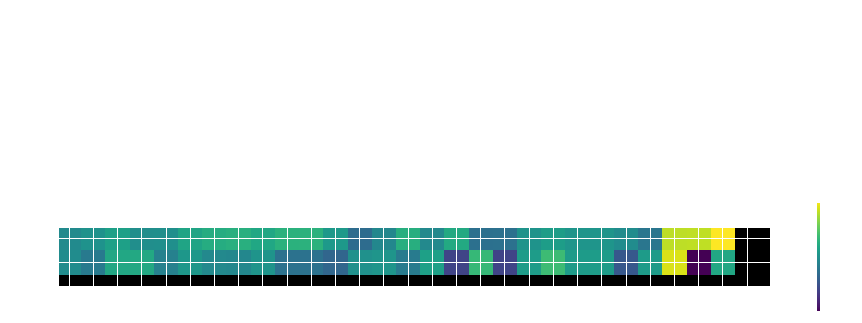

In [54]:
plt.matshow(pca.components_, cmap = 'viridis')

plt.yticks([0, 1, 2], 
           ['feature 1', 'feature 2'], 
           fontsize = 10)

plt.colorbar()

plt.xticks(range(len(df.columns)),
           df.columns, 
           rotation = 90, 
           ha = 'left')

plt.tight_layout()
plt.show()#

#### Separate useless & useful

In [55]:
useless_features = list(df.columns[0:24])
useless_features

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'Churn',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Bank transfer (automatic)']

[Text(0.5, 0, 'gender'),
 Text(1.5, 0, 'SeniorCitizen'),
 Text(2.5, 0, 'Partner'),
 Text(3.5, 0, 'Dependents'),
 Text(4.5, 0, 'PhoneService'),
 Text(5.5, 0, 'OnlineSecurity'),
 Text(6.5, 0, 'OnlineBackup'),
 Text(7.5, 0, 'DeviceProtection'),
 Text(8.5, 0, 'TechSupport'),
 Text(9.5, 0, 'StreamingTV'),
 Text(10.5, 0, 'StreamingMovies'),
 Text(11.5, 0, 'PaperlessBilling'),
 Text(12.5, 0, 'Churn'),
 Text(13.5, 0, 'MultipleLines_No'),
 Text(14.5, 0, 'MultipleLines_No phone service'),
 Text(15.5, 0, 'MultipleLines_Yes'),
 Text(16.5, 0, 'InternetService_DSL'),
 Text(17.5, 0, 'InternetService_Fiber optic'),
 Text(18.5, 0, 'InternetService_No'),
 Text(19.5, 0, 'Contract_Month-to-month'),
 Text(20.5, 0, 'Contract_One year'),
 Text(21.5, 0, 'Contract_Two year'),
 Text(22.5, 0, 'PaymentMethod_Bank transfer (automatic)')]

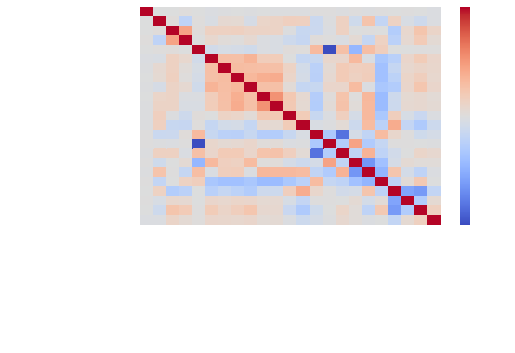

In [56]:
s = sns.heatmap(df[useless_features].corr(), 
                cmap = 'coolwarm')

s.set_yticklabels(s.get_yticklabels(), 
                  rotation = 45, fontsize = 8)

s.set_xticklabels(s.get_xticklabels(), 
                  rotation = 35, fontsize = 8)

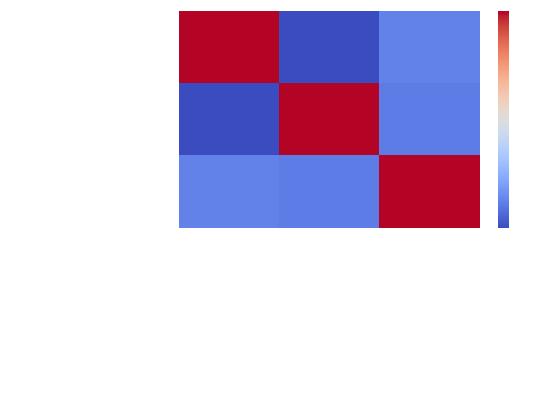

In [57]:
useful_features = list(df.columns[25:28])
useful_features

e = sns.heatmap(df[useful_features].corr(),
                cmap = 'coolwarm')

s.set_yticklabels(s.get_yticklabels(), 
                  rotation = 45, fontsize = 8)

s.set_xticklabels(s.get_xticklabels(), 
                  rotation = 45, fontsize = 7)

plt.show()

In [58]:
data = df[['PaymentMethod_Electronic check',
           'PaymentMethod_Mailed check',
           'tenure']]

Y = data.values

Y_std = StandardScaler().fit_transform(Y)

mean_vec = np.mean(Y_std, axis = 0)

# Covariance matrix
cov_mat = np.cov(Y_std.T)

# eigen pairs
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# pairs in tuple
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse = True)

In [59]:
total_var = sum(eig_vals)

individual_var = [(i / total_var) * 100 for i in sorted(eig_vals, reverse = True)]

cum_var_explained = np.cumsum(individual_var)
cum_var_explained

array([ 46.26316909,  85.37861918, 100.        ])

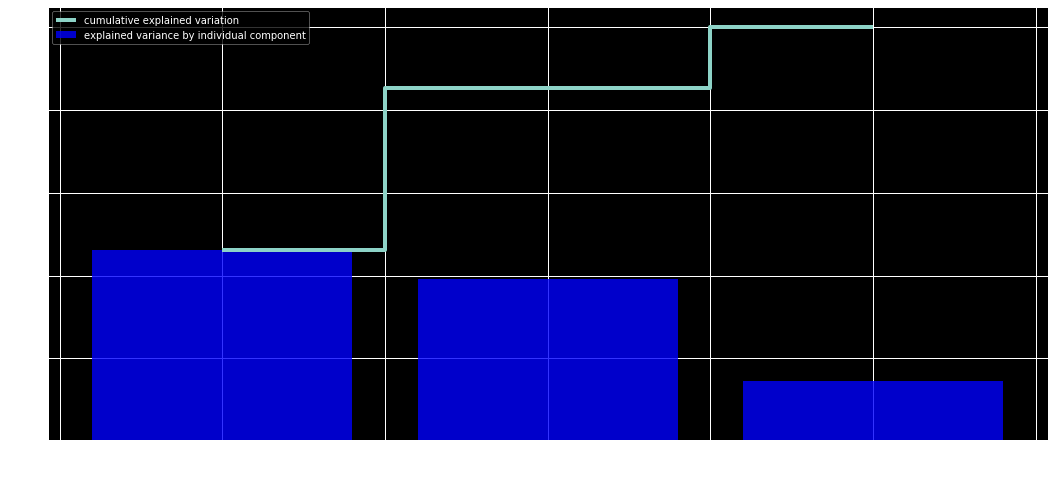

In [60]:
plt.figure(figsize = (16, 8))
plt.bar(range(len(individual_var)), individual_var,
        alpha = 0.8,
        align = 'center',
        label = 'explained variance by individual component',
        color = 'b')

plt.step(range(len(cum_var_explained)
              ), cum_var_explained,
         where = 'mid',
         label = 'cumulative explained variation')

plt.xlabel('PC')
plt.ylabel('explained variance ratio')
plt.legend(loc = 'best')
plt.show();

#### n components = 3

# 6) Binary distribution radar

In [61]:
# Isolate binary col
binary_col = df.nunique()[df.nunique() == 2].keys() # extract cols with 2 values 

radar = df[binary_col]

In [62]:
# Radar configuration 
# plot churned & unchurned distribution

def radar_plot(df, aggregate, title):
    data_frame = df[df['Churn'] == aggregate] 
    data_frame_x = data_frame[binary_col].sum().reset_index()
    data_frame_x.columns = ['feature', 'Yes']
    data_frame_x['No'] = data_frame.shape[0] - data_frame_x['Yes'] # No = unchurned 
    data_frame_x = data_frame_x[data_frame_x['feature'] != 'Churn']
    
    # 1 = Yes, churned 
    trace1 = go.Scatterpolar(r = data_frame_x['Yes'].values.tolist(),
                             theta = data_frame_x['feature'].tolist(),
                             fill = 'toself',
                             name = '1 count',
                             mode = 'markers + lines',
                             marker = dict(size = 5)
                            )
    
    # 0 = No, unchurned 
    trace2 = go.Scatterpolar(r = data_frame_x['No'].values.tolist(),
                             theta = data_frame_x['feature'].tolist(),
                             fill = 'toself',
                             name = ' 0 count',
                             mode = 'markers + lines',
                             marker = dict(size = 5)
                            )
    
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = 'counterclockwise',
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = 'white',
                                                           gridwidth = 2),
                                        angularaxis = dict(tickfont = dict(size = 10),
                                                           layer = 'below traces'),
                                        bgcolor = 'rgb(250, 250, 250)',
                                        ),
                           title = title,
                        height = 800))
    
    data = [trace2, trace1] # Unchurned = Blue, Churned = Red
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)
    
radar_plot(radar, 1, 'Churned')
radar_plot(radar, 0, 'Unchurned')